In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from matplotlib import pylab
import scipy.optimize as opt
from scipy.fftpack import fft,ifft,fftfreq,fft2,ifft2

1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



estimated max speed in 50 years: 32.97989844019469


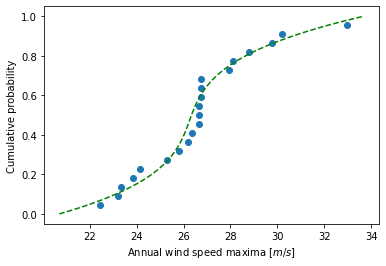

In [9]:
#carico i dati
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]

#il vettore contenente le probabilità cumulative p_i può essere generato con arange visto che a meno di una costante sono gli anni di osservazione a partire dal primo
cp = (np.arange(years_nb) + 1)/(years_nb + 1) #o faccio arange(1,years_nb+1) o semplicemente traslo tutto di una unità

#sorting delle velocità e calcolo con spline della quantile function come suggerito
sorted_max_speeds = np.sort(max_speeds)
quantile_func = UnivariateSpline(cp, sorted_max_speeds)

#adesso posso calcolare il valore cercato come suggerito nel testo
fifty_prob = 1. - 0.02
fifty_wind = quantile_func(fifty_prob)
print("estimated max speed in 50 years:",fifty_wind)

#plot di velocità vs cp
plt.figure()
plt.scatter(sorted_max_speeds,cp);
plt.xlabel('Annual wind speed maxima [$m/s$]');
plt.ylabel('Cumulative probability');

#posso anche graficare la stessa quantile function
nprob = np.linspace(0, 1, 100)
fitted_max_speeds = quantile_func(nprob)
plt.plot(fitted_max_speeds, nprob, 'g--');

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

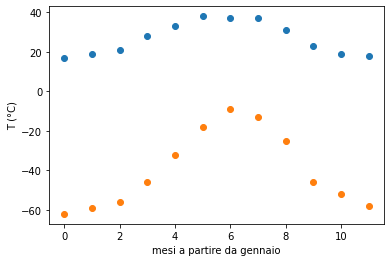

In [20]:
max_temp = np.array([17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18])
min_temp = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
t = np.arange(max_temp.size) #mesi a partire da gennaio fino a dicembre
fig,ax = plt.subplots();
ax.scatter(t,max_temp);
ax.scatter(t,min_temp);
ax.set_xlabel("mesi a partire da gennaio");
ax.set_ylabel("T (°C)");

a,b,c,d (min. temp., gauss.): [ 52.64929291   0.12806779   6.16452589 -61.32093897]
a,b,c,d (max. temp., gauss.): [23.09208216  0.09497704  5.73581611 15.77932687]


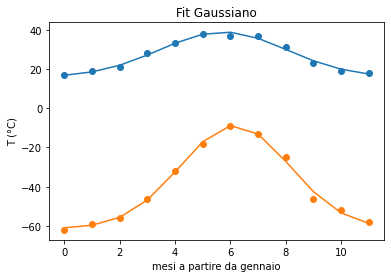



a,b,c,d (min. temp., seno): [-25.14962089   0.60132054   5.2586927  -36.71257722]
a,b,c,d (max. temp., seno): [-10.58169953   0.59227424   4.96024843  27.94963537]


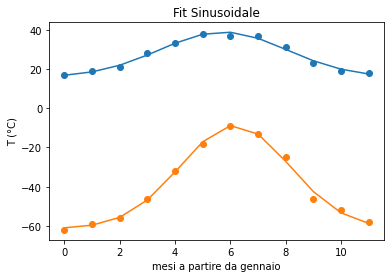

time offset, min vs max (gaussian): 6.164525890401087 5.7358161070804075
time offset, min vs max (sin): 5.258692704997482 4.960248425602147


In [33]:
#andando ad occhio basterebbe ad esempio una gaussiana per fittare entrambe le curve. Tuttavia ricordando che abbiamo a disposizione i dati relativi ad un unico anno è ragionevole aspettarsi che se potessimo osservare i dati relativi a più anni osserveremmo un andamento più o meno periodico, che nel migliore dei casi potrebbe essere fittato con un seno o un coseno opportunamente modulato/traslato (o comunque da una somma di un numero relativamente basso di funzioni goniometriche opportunamente scalate). Per questo motivo effettuo sia un fit "naif" con una gaussiana che uno con un seno/coseno, che è il più semplice tipo di funzione periodica. 
#Ovviamente aumentare i parametri liberi aumenta il numero di gradi di libertà a disposizione del nostro fit, e quindi in linea di principio conviene usare un numero enorme di coefficienti; tuttavia dal plot precedente penso ne bastino 4, due per controllare la scala orizzontale/verticale e due per controllare l'eventuale traslazione orizzontale/verticale

def gaussiana(x,a,b,c,d) :
    #a effettua uno scaling dell'asse verticale, b di quello orizzontale (in un certo senso fissano le unità di misura opportune sui due assi); c è la media della gaussiana e pertanto decide la traslazione lungo l'asse x, mentre d essendo una costante a sommare fissa la traslazione lungo l'asse y
    return a*np.exp(-b*(x-c)**2)+d #b è l'analogo di 1/sigma^2, c di mu; scrivo la gaussiana in questo modo "standard" in modo da poter dare ai parametri una interpretazione geometrica semplice come media, std dev, eccetera; in questo modo posso facilmente stimarli a occhio dalla figura per ottenere delle stime ragionevoli per p0 sotto

def seno(x,a,b,c,d) :
    #similmente a sopra a è l'ampiezza e quindi scala la funzione lungo y, b è la frequenza e quindi scala lungo x, c è la fase e quindi trasla lungo x, d è una costante a sommare e quindi trasla lungo y
    return a*np.sin(b*x-c)+d

#------------Fit Gaussiano--------------------
par_min_gauss,par_min_gauss_cov = opt.curve_fit(gaussiana,t,min_temp,p0=[60,1/np.sqrt(2),6,-60])#a occhio dalla figura stimo facilmente (nell'ordine): ampiezza (scaling verticale), dev. std. (scaling orizzontale), media (traslazione orizzontale) e traslazione verticale
print("a,b,c,d (min. temp., gauss.):",par_min_gauss)
#print("a,b,c,d cov. (min. temp., gauss.):",par_min_gauss_cov) #eventualmente da decommentare se serve

par_max_gauss,par_max_gauss_cov = opt.curve_fit(gaussiana,t,max_temp,p0=[20,1/np.sqrt(2),6,-60])#a occhio dalla figura stimo ...
print("a,b,c,d (max. temp., gauss.):",par_max_gauss)
#print("a,b,c,d cov. (max. temp., gauss.):",par_max_gauss_cov)

#plt.scatter(t,max_temp)
#plt.scatter(t,min_temp)
#plt.plot(gaussiana(t,*par_max_gauss));
#plt.plot(gaussiana(t,*par_min_gauss));
#plt.title("Fit Gaussiano");
#plt.xlabel("mesi a partire da gennaio");
#plt.ylabel("T (°C)");

fig_g,ax_g = plt.subplots();
ax_g.scatter(t,max_temp);
ax_g.scatter(t,min_temp);
ax_g.plot(gaussiana(t,*par_max_gauss));
ax_g.plot(gaussiana(t,*par_min_gauss));
ax_g.set_title("Fit Gaussiano")
ax_g.set_xlabel("mesi a partire da gennaio");
ax_g.set_ylabel("T (°C)");
plt.show()
#-------------Fit Sinusoidale------------------
print("\n")

par_min_seno,par_min_seno_cov = opt.curve_fit(seno,t,min_temp,p0=[30,2*np.pi/12,4,-30])#a occhio dalla figura stimo facilmente (nell'ordine): ampiezza (scaling verticale) (che adesso è la metà di prima a causa del comportamento oscillante del seno), frequenza (scaling orizzontale) (adesso uso il periodo che a occhio e con la logica è di 12 mesi), fase (traslazione orizzontale) (si "azzera" rispetto alla media circa a 4, quindi sottraggo 4 all'argomento con il meno già integrato) e traslazione verticale (oscilla attorno ad una media di circa -30)
print("a,b,c,d (min. temp., seno):",par_min_seno)
#print("a,b,c,d cov. (min. temp., seno):",par_min_seno_cov) #eventualmente da decommentare

par_max_seno,par_max_seno_cov = opt.curve_fit(seno,t,max_temp,p0=[10,2*np.pi/12,4,30])#a occhio dalla figura stimo ...
print("a,b,c,d (max. temp., seno):",par_max_seno)
#print("a,b,c,d cov. (max. temp., seno):",par_max_seno_cov)

plt.scatter(t,max_temp)
plt.scatter(t,min_temp)
plt.plot(gaussiana(t,*par_max_gauss));
plt.plot(gaussiana(t,*par_min_gauss));
plt.title("Fit Sinusoidale");
plt.xlabel("mesi a partire da gennaio");
plt.ylabel("T (°C)");
plt.show()

print("time offset, min vs max (gaussian):",par_min_gauss[2],par_max_gauss[2]) #entrambi circa 6
print("time offset, min vs max (sin):",par_min_seno[2],par_max_seno[2]) #entrambi circa 5, ok

3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pylab.imshow() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


min. estimated on sight: [-2.    0.75]
min n.1: [-0.08984237  0.71265591] 

min. estimated on sight: [0.   0.75]
min n.2: [-0.08984202  0.71265641] 

min. estimated on sight: [ 0.   -0.75]
min n.3: [ 0.08984201 -0.71265642] 

min. estimated on sight: [ 2.   -0.75]
min n.4: [ 0.08984236 -0.71265592] 

min. estimated on sight: [-2.   -0.75]
min n.5: [ 0.08984175 -0.71265629] 

min. estimated on sight: [2.   0.75]
min n.6: [-0.08984177  0.71265627] 



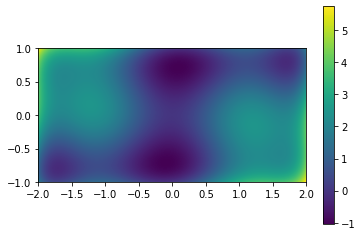

In [74]:
def fun(XY) :
    x, y = XY[0], XY[1] # senza non mi funziona minimize
    return (4-2.1*x**2+x**4/3)*x**2+x*y+(4*y**2-4)*y**2

h = 0.01
x_values, y_values = np.arange(-2,2+h,h),np.arange(-1,1+h,h)
X, Y = np.meshgrid(x_values, y_values)
Z = fun([X,Y])
#plt.pcolor(X,Y,Z); #plt.pcolor() funziona come pylab.imshow() ma siccome permette di specificare anche X e Y dà subito gli assi giusti. Alternativa: imshow con extent=[-2,2,-1,1]
pylab.imshow(Z,extent=[-2,2,-1,1]) #così è più veloce, pare
#plt.contour(X,Y,Z)
plt.colorbar(); # a occhio i minimi sono in (-2,0.75), (0,0.75), (0,-0.75), (2,-0.75), (-2,-0.75), (2,0.75)
est_min = np.array([[-2,0.75], [0,0.75], [0,-0.75], [2,-0.75], [-2,-0.75], [2,0.75]])
min = np.zeros((est_min.shape[0],2))
for i,xy in enumerate(est_min) :
    min[i,:] = opt.minimize(fun,x0=xy).x
    print("min. estimated on sight:",xy)
    print(f"min n.{i+1}: {min[i]}","\n")

Il minimo della funzione è: [-0.08984237  0.71265591] 
La funzione nel punto di minimo vale: -1.0316284534871936


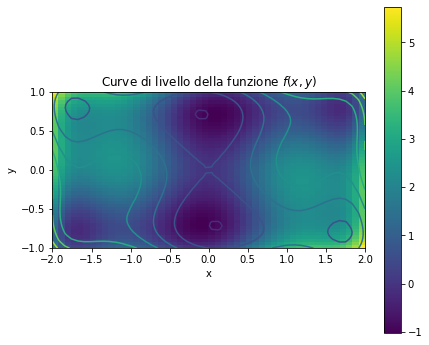

In [67]:
def function(number) :
    x = number[0]
    y = number[1]
    return (4-2.1*x**2+x**4/3)*x**2+x*y+(4*y**2-4)*y**2
x_plot = np.linspace(-2,2)
y_plot = np.linspace(-1,1) 
# ho costruito i due vettori x e y con cui poter calcolare l'output della funzione f(x,y). Naturalmente avremo bisogno di tutte le possibili coppie di punti (x,y) ottenibili dai due array. In totale sono 50*50=2500 punti dei quali calcolare la quota. 
xx, yy = np.meshgrid(x_plot, y_plot)
fig, ax = plt.subplots(1,1, figsize=(7,6))
ax.set_title('Curve di livello della funzione $f(x,y)$')
ax.set_xlabel('x')
ax.set_ylabel('y')
image_fun = ax.imshow(function([xx,yy]), extent=[-2,2,-1,1])
ax.contour(xx,yy,function([xx,yy]))
# aggiungo al color plot anche le curve di livello per comprendere quali siano i piani paralleli a z che intersecano la funzione in punti con la stessa quota 
fig.colorbar(image_fun)
# per far funzionare il metodo optimize.minimize è necessario usare una function che abbia come argomento un unico array ed eventualmente dei parametri costanti fissati a priori
x_min = opt.minimize(function, x0=xy)
print('Il minimo della funzione è:', x_min['x'],'\nLa funzione nel punto di minimo vale:', function(x_min['x']))
# Se partissimo invece dal punto (0,0) come vediamo anche dalle curve di livello ci troviamo in un punto in cui l'algoritmo non riesce ad aggiornare l'argomento della funzione e rimane lì dove è partito

4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

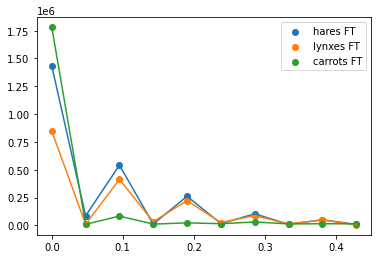

In [66]:
data = np.loadtxt('populations.txt')
year, hares, lynxes, carrots = data.T

#f,tf = fftfreq(year.size), fft(hares)
#plt.plot(f,np.abs(tf));
#plt.scatter(f,np.abs(tf));
#print(tf.size)
#print(np.abs(tf))

def frequency_spectrum(x) :
    n = x.size #si dimostra facilmente che il modulo della trasformata di Fourier di una funzione reale è pari, quindi ci basta prendere metà del vettore sbarazzandoci delle frequenze negative (per compensare moltiplichiamo per 2 in modo da poter ancora ricostruire la funzione di partenza)
    if n%2 == 0 :
        return fftfreq(n)[:int(n/2)], 2*np.abs(fft(x)[:int(n/2)])
    else :
        return fftfreq(n)[:int((n-1)/2)], 2*np.abs(fft(x)[:int((n-1)/2)])
plt.plot(*frequency_spectrum(hares));
plt.scatter(*frequency_spectrum(hares),label="hares FT");
plt.plot(*frequency_spectrum(lynxes));
plt.scatter(*frequency_spectrum(lynxes),label="lynxes FT");
plt.plot(*frequency_spectrum(carrots));
plt.scatter(*frequency_spectrum(carrots),label="carrots FT");
plt.legend();
#sono presenti le stesse armoniche con pesi molto simili

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

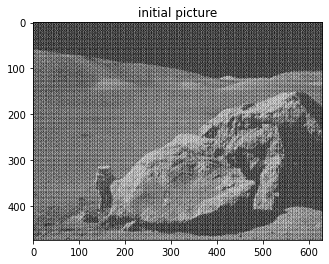

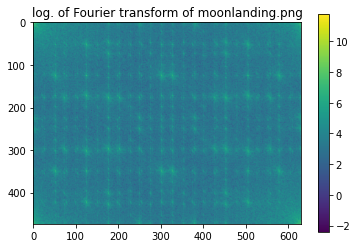

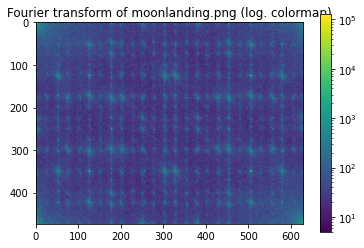

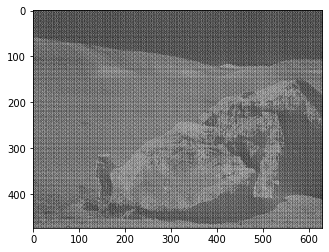

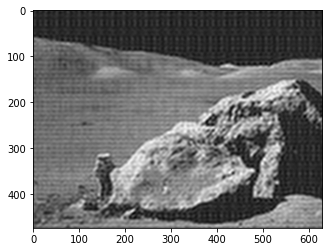

In [102]:
from IPython.display import Image,display
#display(Image("moonlanding.png"))
im = pylab.imread("moonlanding.png")
pylab.imshow(im,plt.cm.gray)
plt.title("initial picture") 
plt.show()

ft = fft2(im)
plt.imshow(np.log(np.abs(ft))) #senza la scala logaritmica non si riescono ad apprezzare le differenze fra le varie parti dell'immagine, i punti dove la potenza è elevata sono "nascosti" in un mare magnum di punti dove è bassa; o uso una colormap logaritmica o faccio direttamente il plot del logaritmo della potenza
plt.colorbar()
plt.title("log. of Fourier transform of moonlanding.png")
plt.show()

plt.figure()
from matplotlib.colors import LogNorm
plt.imshow(np.abs(ft), norm=LogNorm(vmin=5)) #http://scipy-lectures.org/intro/scipy/auto_examples/solutions/plot_fft_image_denoise.html
plt.colorbar()
plt.title("Fourier transform of moonlanding.png (log. colormap)")
plt.show()

r,c = ft.shape
ft_clean_image = ft.copy()
ft_clean_image[int(r*0.9):,int(c*0.9):] = 0 #leggendo la descrizione di primo acchito ho pensato ad esempio di eliminare il 10% in cima sia su x che su y e il risultato non è granché, anzi si perde nitidezza...
clean_image = ifft2(ft_clean_image).real
pylab.imshow(clean_image,plt.cm.gray);
plt.show()

#nello stesso link di cui sopra consigliano in realtà di tenere il 10% in cima visto che contiene il grosso della variabilità e di invece eliminare qualcosa "al centro" fra le componenti più rapidamente variabili e quelle lente che definiscono "la base" dell'immagine
r,c = ft.shape
ft_clean_image = ft.copy()
ft_clean_image[int(r*0.1):int(r*0.9)] = 0
ft_clean_image[:,int(c*0.1):int(c*0.9)] = 0
clean_image = ifft2(ft_clean_image).real
pylab.imshow(clean_image,plt.cm.gray);
plt.show() #in effetti il risultato è ben superiore per contrasto